## Steps to merge the global Free-flowing river and GRanD dam datasets
### Process GRanD data & Join GRanD and FFR based on GOID
The FFR dataset is very large and needed to be downloaded in pieces. We looped through a geometry filter based on continent boundaries to load FFR in reasonable chunks and then applied a function to join the Grand and FFR data based on the unique GOID.

### 6/23/21

In [1]:
# Import packages, set working directory
import os

import pandas as pd
import geopandas as gpd
import zipfile
import earthpy as et
import urllib.request

# Import custom .py module for merging data functions
import data_merge_fxn as dfxn

In [2]:
# Set working directory
wrk_dir_path = os.path.join(et.io.HOME,"earth-analytics","data")

# Conditional statement to set working directory if it exists or create one if it doesn't exist
if os.path.exists(wrk_dir_path):
    os.chdir(wrk_dir_path)
    print("The specified directory exists and is now the working directory")
else:
    os.makedirs(wrk_dir_path)
    os.chdir(wrk_dir_path)
    print("There currently is not a directory", wrk_dir_path,
          "but it is being created and called to be the working directory.")

# DATA FILE PATHS
# Continent boundaries
continent_path = os.path.join("earthpy-downloads", "continent-poly", "Continents.shp")

# Country boundaries
countries_path = os.path.join("earthpy-downloads", "country-borders",
                              "99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp")

# Define path to GRanD file
dam_path = os.path.join("earthpy-downloads", "GRanD_Version_1_3","GRanD_dams_v1_3.shp")

# Define path to unzipped FFR
ffr_path = os.path.join("earthpy-downloads", "Mapping%20the%20worlds%20free-flowing%20rivers_Data_Geodatabase",
                          "Mapping the worlds free-flowing rivers_Data_Geodatabase",
                          "FFR_river_network.gdb")

# CONDITIONAL STATEMENTS TO SEE IF DATA ARE ALREADY STORED LOCALLY AND IF NOT, GET DATA
if os.path.exists(continent_path):
    continent_border = gpd.read_file(continent_path)
    print("The continent path exists and data are downloaded")
else:
    et.data.get_data(url="https://ndownloader.figshare.com/files/23392280")
    continent_border = gpd.read_file(continent_path)
    print("Needed to retrieve continent data from url and data are downloaded")
    
if os.path.exists(countries_path):
    countries_border = gpd.read_file(countries_path)
    print("The countries path exists and data are downloaded")
else:
    et.data.get_data(url="https://ndownloader.figshare.com/files/22507058")
    countries_border = gpd.read_file(countries_path)
    print("Needed to retrieve country data from url and data are downloaded")
    
if os.path.exists(dam_path):
    global_dams = gpd.read_file(dam_path)
    print("The dam path exists and data are downloaded")
else:
    et.data.get_data(url="https://ln.sync.com/dl/bd47eb6b0/anhxaikr-62pmrgtq-k44xf84f-pyz4atkm/view/default/447819520013")#
    with zipfile.ZipFile("GRanD_Version_1_3.zip","r") as zip_ref:
        zip_ref.extractall("earthpy-downloads")
    print('File is unzipped in earthpy-downloads folder') 
    global_dams = gpd.read_file(dam_path)
    print("Unzipped dam data are downloaded")

# Free-flowing rivers - just wanted to see if data are unzipped somewhere
if os.path.exists(ffr_path):
    print("The river path exists with unzipped data")
else:
    et.data.get_data(url="https://ndownloader.figshare.com/files/15090536")
    with zipfile.ZipFile("Mapping the worlds free-flowing rivers_Data_Geodatabase.zip","r") as zip_ref:
        zip_ref.extractall("earthpy-downloads")
    print('River file is now unzipped in earthpy-downloads folder')
    

The specified directory exists and is now the working directory
The continent path exists and data are downloaded
The countries path exists and data are downloaded
The dam path exists and data are downloaded
The river path exists with unzipped data


In [3]:
# Load processed GRanD.csv with FFR unique ID
grand_csv_path = os.path.join(
    "GRanDv13_GOID.csv")

# Import .csv into Pandas dataframe
grand_csv = pd.read_csv(grand_csv_path,
                        na_values=[-9999])

# See number of dams missing GOID
print('Number of observations without GOID =', grand_csv['GOID'].isnull().sum())

# Need to fill in NAs to be able to convert to an integer
grand_csv = grand_csv.fillna(-9999)

# REDUCE COLUMNS TO ONLY ONES OF INTEREST FOR MERGE
grand_csv = grand_csv[["GRAND_ID","GOID"]]

# Convert GOID to integer
grand_csv['GOID'] = grand_csv['GOID'].astype(int)

Number of observations without GOID = 7


In [4]:
# PROCESS GRanD shapefile dataframe
# Convert GRAND_ID to an object to merge with processed dam data subset
global_dams['GRAND_ID'] = global_dams['GRAND_ID'].astype(str)

In [5]:
# MERGE PROCESSED GRAND CSV WITH SHAPEFILE GRAND TO GET GOID COLUMN
grand_proc = global_dams.merge(grand_csv, on= "GRAND_ID", how= "inner")

grand_proc = grand_proc.drop(columns=['COUNTRY']) #,'geometry'
grand_proc['GOID'] = grand_proc['GOID'].astype(int)

In [6]:
# 1) MAIN_RED - reduce dams 'recreation','fisheries', & 'other' to a general 'other' category
dfxn.reduce_dam(grand_proc=grand_proc, new_class='MAIN_RED')
grand_proc['MAIN_RED'].value_counts()

Irrigation          1896
Hydroelectricity    1822
Water supply         892
Flood control        577
Other expanded       516
Navigation            56
Name: MAIN_RED, dtype: int64

In [7]:
# 2) MAIN_HYDEXP - use function to reclassify dams with hydroelectricity listed as secondary use
dfxn.reclass_dam(grand_proc=grand_proc, new_class='MAIN_HYDEXP')
grand_proc.columns
grand_proc['MAIN_HYDEXP'].value_counts()

Hydroelectricity    1822
Irrigation          1527
Water supply         789
Other expanded       516
Flood control        412
Hydro_irrig          355
Hydro_flood          163
Hydro_water          100
Navigation            34
Hydro_navig           22
Hydro_other           19
Name: MAIN_HYDEXP, dtype: int64

In [8]:
# 3) MAIN_HYDRO - Reclassify dams with hydroelectricity listed as any use
dfxn.reclass_hydro(grand_proc = grand_proc, new_class= 'MAIN_HYDRO')
grand_proc.columns
grand_proc['MAIN_HYDRO'].value_counts()


Hydroelectricity    2481
Irrigation          1527
Water supply         789
Other expanded       516
Flood control        412
Navigation            34
Name: MAIN_HYDRO, dtype: int64

In [9]:
# 4) CREATE DUMMY VARIABLE TO INDICIATE WHETHER HYDROELECTRICITY IS ANY PURPOSE (Y = 1; N = 0)
dfxn.reclass_dummy(grand_proc=grand_proc, new_class= 'HYDELEC_code')
grand_proc.columns
grand_proc['HYDELEC_code'].value_counts()

0    4839
1    2481
Name: HYDELEC_code, dtype: int64

In [10]:
# CHECKS ON NEWLY CREATED DAM PURPOSE CLASSES
# Check number of observations missing dam usage to make sure reclassification adds up
if grand_proc['MAIN_HYDEXP'].count()==global_dams['MAIN_USE'].count():
    print("Number of dams with a main use designation is correct and equal to",global_dams['MAIN_USE'].count())
else:
    print("Number of dams with a main use designation is different between 'MAIN_USE' & 'MAIN_HYDEXP'.")

# Check if number of recoded hydroelectric dams adds up
if grand_proc['HYDELEC_code'][grand_proc['HYDELEC_code']=='1'].count() == grand_proc['MAIN_HYDRO'][grand_proc['MAIN_HYDRO']=='Hydroelectricity'].count():
    print("Number of classified hydroelectric dams is correct and equal to",
         grand_proc['HYDELEC_code'][grand_proc['HYDELEC_code']=='1'].count())
else:
    print("Number of hydroelectric dams is different between 'HYDELEC_code' & 'MAIN_HYDRO'." )

Number of dams with a main use designation is correct and equal to 5759
Number of classified hydroelectric dams is correct and equal to 2481


In [15]:
# MERGE FFR and Processed GRanD using merge function and 
#  looping through geometry filter based on continent boundary

# Create an empty list to populate with geodataframes
merge_dfs = []
for acontinent in continent_border['CONTINENT']:
    ffr_subset = gpd.read_file(ffr_path,
                              mask=continent_border[continent_border['CONTINENT']==
                                                    acontinent],)
    ffr_grand_subset = dfxn.grand_ffr_join(grand_dat = grand_proc,
                                     ffr_dat = ffr_subset)
    
    merge_dfs.append(ffr_grand_subset)

all_ffr_grand = pd.concat(merge_dfs)

all_ffr_grand

,GRAND_ID,RES_NAME,DAM_NAME,ALT_NAME,RIVER,ALT_RIVER,MAIN_BASIN,SUB_BASIN,NEAR_CITY,ALT_CITY,...,RDD,FLD,CSI,CSI_D,CSI_FF,CSI_FF1,CSI_FF2,CSI_FFID,Shape_Length,geometry_y
0,2555,None,Diama,None,Senegal,None,Senegal,None,Saint-Louis,None,...,0.000,59.689999,19.95024,DOF,0,3,3,261849,0.056189,"MULTILINESTRING ((-16.41458 16.21875, -16.4229..."
1,2928,None,Sghir,None,Sghir,None,Mediterranean Coast,Rif,Tanger,None,...,0.128,43.536999,52.52858,DOF,0,3,3,4438,0.066963,"MULTILINESTRING ((-5.38542 35.68542, -5.38125 ..."
2,2929,None,Ibn Batouta,None,Mharhar,None,Mediterranean Coast,Rif,Tanger,None,...,0.000,45.783001,31.61437,DOF,0,3,3,4585,0.046844,"MULTILINESTRING ((-5.72292 35.63542, -5.72708 ..."
3,2930,None,Ajras,None,Ajras,None,Mediterranean Coast,Rif,Tetouan,None,...,2.176,0.439000,47.76043,DOF,0,3,3,4539,0.095057,"MULTILINESTRING ((-5.56250 35.54375, -5.55208 ..."
4,2931,None,Nakhla,None,Nakhla,En Nakhla,Mediterranean Coast,Rif,Tetouan,None,...,1.419,5.405000,44.62490,DOF,0,3,3,4537,0.040237,"MULTILINESTRING ((-5.39375 35.43542, -5.40625 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246,7053,None,Arenoso,None,Arenoso,None,Guadalquivir,None,Montoro,None,...,0.000,0.000000,100.00000,NAN,1,1,1,1134106,0.008839,"MULTILINESTRING ((-5.63750 38.02083, -5.63125 ..."
1247,7056,None,Los Melonares,Presa de Melonares,Viar,None,Guadalquivir,None,Castilblanco de los Arroyos,El Pedroso,...,1.091,0.000000,98.95545,USE,1,1,1,1135198,0.040742,"MULTILINESTRING ((-2.68333 37.73333, -2.67292 ..."
1248,7058,None,Mularroya,None,Grio,None,Ebro,None,la Almunia de Dona Godina,None,...,0.000,83.929001,57.76359,DOF,0,3,3,1094211,0.028452,"MULTILINESTRING ((0.16875 41.40625, 0.17708 41..."
1249,7059,None,San Salvador,None,Arroyo de la Clamor,None,Ebro,None,Albalate de Cinca,"Belver de Cinca, Binaced",...,3.901,0.000000,99.80495,RDD,1,1,1,1094824,0.065028,"MULTILINESTRING ((1.27500 41.78750, 1.26042 41..."


<AxesSubplot:>

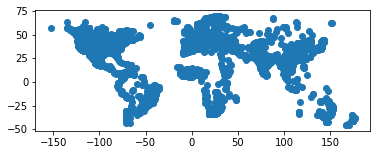

In [16]:
# SPECIFY GEOMETRY 
# Drop geometry column from FFR and rename geometry from GRanD
all_grand_ffr=all_ffr_grand.drop(['geometry_y'], axis=1)
all_grand_ffr=all_grand_ffr.rename(index=str, columns={"geometry_x":"geometry"})

# Specify geometry column for geodataframe
all_grand_ffr = all_grand_ffr.set_geometry('geometry')
all_grand_ffr.plot()

In [17]:
all_grand_ffr.columns

Index(['GRAND_ID', 'RES_NAME', 'DAM_NAME', 'ALT_NAME', 'RIVER', 'ALT_RIVER',
       'MAIN_BASIN', 'SUB_BASIN', 'NEAR_CITY', 'ALT_CITY', 'ADMIN_UNIT',
       'SEC_ADMIN', 'SEC_CNTRY', 'YEAR', 'ALT_YEAR', 'REM_YEAR', 'DAM_HGT_M',
       'ALT_HGT_M', 'DAM_LEN_M', 'ALT_LEN_M', 'AREA_SKM', 'AREA_POLY',
       'AREA_REP', 'AREA_MAX', 'AREA_MIN', 'CAP_MCM', 'CAP_MAX', 'CAP_REP',
       'CAP_MIN', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM',
       'CATCH_REP', 'DATA_INFO', 'USE_IRRI', 'USE_ELEC', 'USE_SUPP',
       'USE_FCON', 'USE_RECR', 'USE_NAVI', 'USE_FISH', 'USE_PCON', 'USE_LIVE',
       'USE_OTHR', 'MAIN_USE', 'LAKE_CTRL', 'MULTI_DAMS', 'TIMELINE',
       'COMMENTS', 'URL', 'QUALITY', 'EDITOR', 'LONG_DD', 'LAT_DD', 'POLY_SRC',
       'geometry', 'GOID', 'MAIN_RED', 'MAIN_HYDEXP', 'MAIN_HYDRO',
       'HYDELEC_code', 'REACH_ID', 'NOID', 'NUOID', 'NDOID', 'CON_ID',
       'CONTINENT', 'COUNTRY', 'BAS_ID', 'BAS_NAME', 'LENGTH_KM', 'VOLUME_TCM',
       'UPLAND_SKM', 'DIS_AV_

In [18]:
# EXPORT PROCESSED DATA
#all_ffr_grand.dtypes
# WRITE CSV FILE OF MERGED GRAND and FFR DATA FOR WORLD - rearranged order
all_grand_ffr.to_csv (r'C:\Users\Owner\earth-analytics\data\GRAND_FFR.csv', index = False, header=True)

# WRITE CSV FILE OF MERGED FFR AND GRAND DATA FOR WORLD
#all_ffr_grand.to_csv (r'C:\Users\Owner\earth-analytics\data\FFR_GRAND.csv', index = False, header=True)


# WRITE SHAPEFILE OF GRanD dams with river attributes
# CREATE PATH FOR EXPORT
output_path = os.path.join(
    "GRAND_FFR_gdf","GRAND_FFR.shp")

all_grand_ffr.to_file(output_path)

<ipython-input-18-fcf10d0b2482>:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  all_grand_ffr.to_file(output_path)


In [19]:
# Data exploration to make sure it did what we expected
print(all_ffr_grand.shape) # 7303 out of 7320 Grand dams
print(grand_proc.shape)
print(all_ffr_grand['MAIN_USE'].count())
print(grand_proc['MAIN_USE'].count())
print(all_ffr_grand['CONTINENT'].value_counts())

(7303, 101)
(7320, 63)
5748
5759
North America    2125
Asia             2100
Europe           1524
Africa            759
South America     507
Australia         288
Name: CONTINENT, dtype: int64
